# **Meta 1**

 Incluir obstáculos retangulares no espaço de trabalho simulado no 
CoppeliaSim. Considerando que o robô seja de forma quadrada e 
sua orientação não mude, obter o mapa correspondente em espaço 
de configuração. Incluir funcionalidade que permita apresentar o 
caminho do robô.

Obs.: Inserir as seguintes linhas ao script do robô para ser desenhado o caminho

```lua
--lua

sim = require('sim')

function sysCall_init()
    robot = sim.getObject('.')
    robotTrace = sim.addDrawingObject(sim.drawing_linestrip + sim.drawing_cyclic, 8, 0, -1, 400, {1, 1, 0}, nil, nil, {1, 1, 0})
end

function sysCall_sensing()
    local p = sim.getObjectPosition(robot)
    p[3]=0
    sim.addDrawingObjectItem(robotTrace, p)
end 
```


In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import guira

Program started
Connected to remote API server
Número de objetos na simulação: 82
Erro ao obter as dimensões do objeto 0
Erro ao obter min_x para o objeto 1
Erro ao obter as dimensões do objeto 1
Erro ao obter min_x para o objeto 2
Erro ao obter as dimensões do objeto 2
Erro ao obter min_x para o objeto 3
Erro ao obter as dimensões do objeto 3
Erro ao obter min_x para o objeto 4
Erro ao obter as dimensões do objeto 4
Erro ao obter min_x para o objeto 5
Erro ao obter as dimensões do objeto 5
Erro ao obter min_x para o objeto 6
Erro ao obter as dimensões do objeto 6
Erro ao obter min_x para o objeto 7
Erro ao obter as dimensões do objeto 7
Erro ao obter as dimensões do objeto 8
Erro ao obter min_x para o objeto 9
Erro ao obter as dimensões do objeto 9
Erro ao obter min_x para o objeto 10
Erro ao obter as dimensões do objeto 10
Erro ao obter min_x para o objeto 11
Erro ao obter as dimensões do objeto 11
Erro ao obter min_x para o objeto 12
Erro ao obter as dimensões do objeto 12
Ignorando

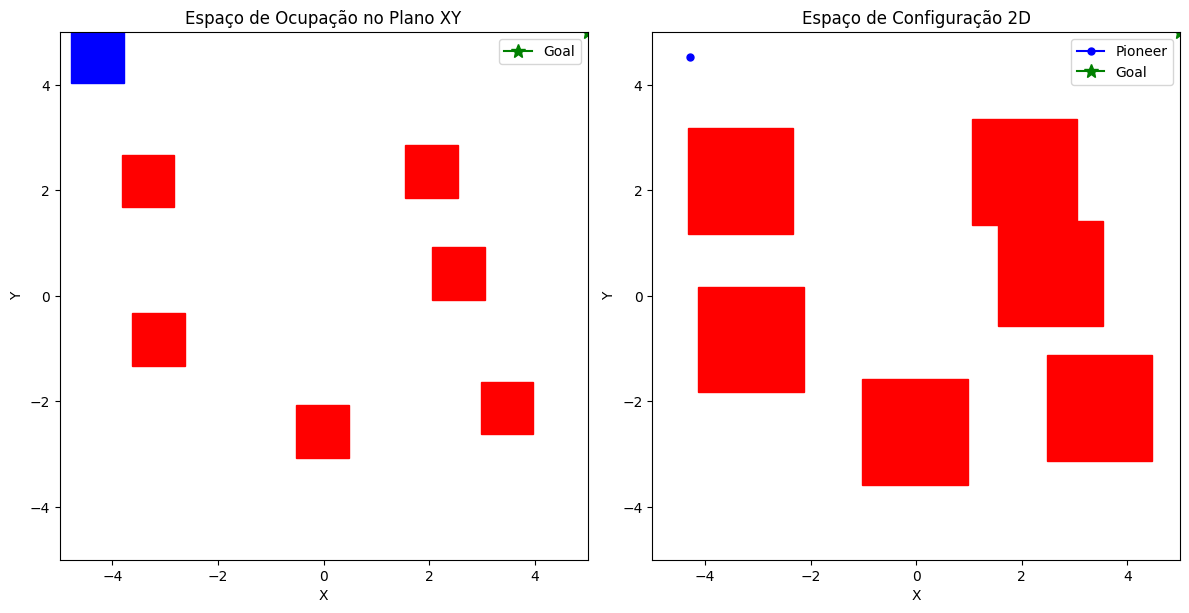

Program ended


In [15]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')
    controller = RobotController(clientID)

    controller.set_goal(np.array([5,5,0]))

    controller.get_map()

    controller.plot_map()
    
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')

Program started
Connected to remote API server


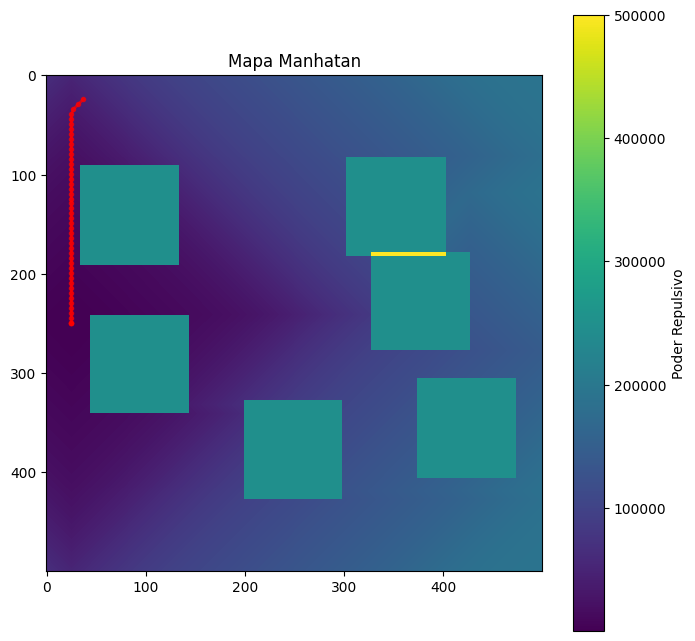

Program ended


In [16]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')

    controller.qi = controller.get_robot_position()

    controller.set_goal(np.array([-4.5,0,0]))
    
    controller.get_generated_path_manha(True)

    controller.send_generated_path()

    controller.control_loop(500)

    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')

Program started
Connected to remote API server
25
(45, 5)
path (25, 24)
path (26, 24)
path (27, 24)
path (28, 24)
path (29, 24)
path (30, 24)
path (31, 24)
path (32, 24)
path (33, 24)
path (34, 24)
path (35, 24)
path (35, 23)
path (35, 22)
path (35, 21)
path (35, 20)
path (35, 19)
path (35, 18)
path (35, 17)
path (35, 16)
path (35, 15)
path (35, 14)
path (35, 13)
path (36, 13)
path (36, 12)
path (36, 11)
path (36, 10)
path (36, 9)
path (36, 8)
path (36, 7)
path (36, 6)
path (36, 5)
path (37, 5)
path (38, 5)
path (39, 5)
path (40, 5)
path (41, 5)
path (42, 5)
path (43, 5)
path (44, 5)
path (45, 5)
Program ended


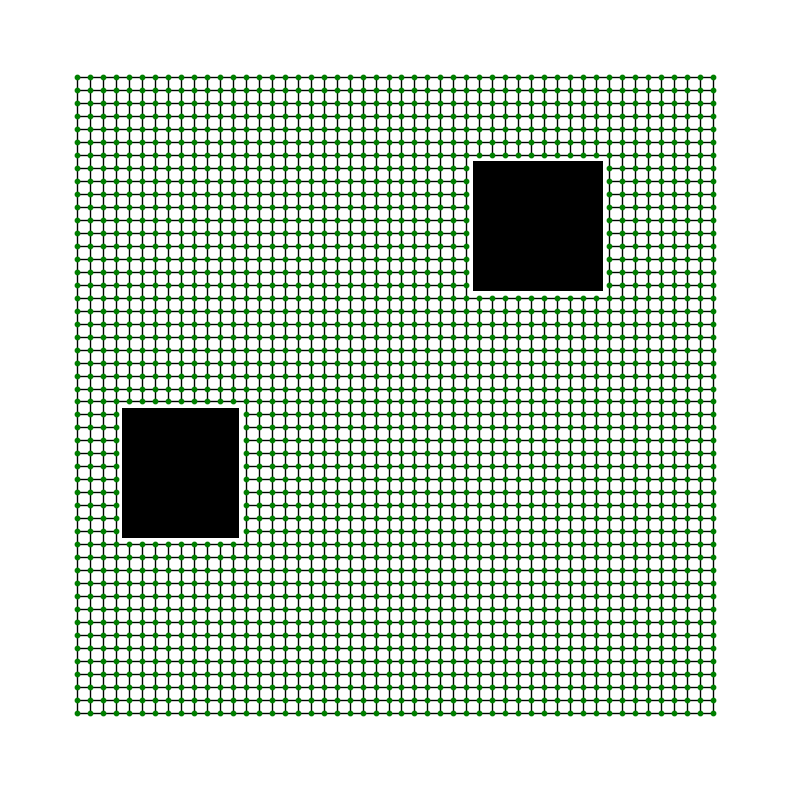

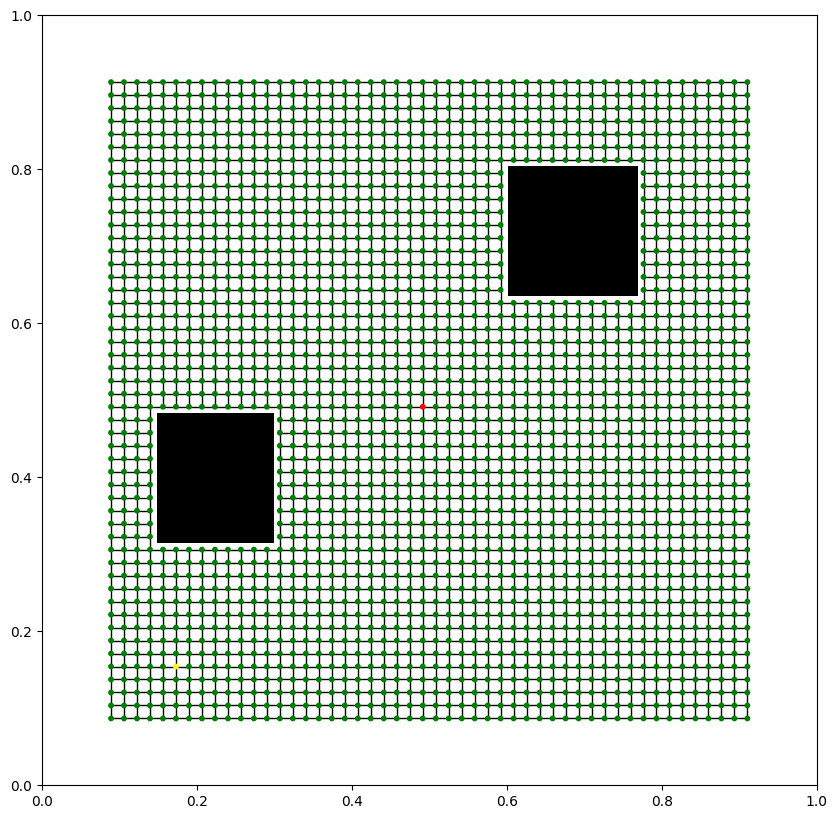

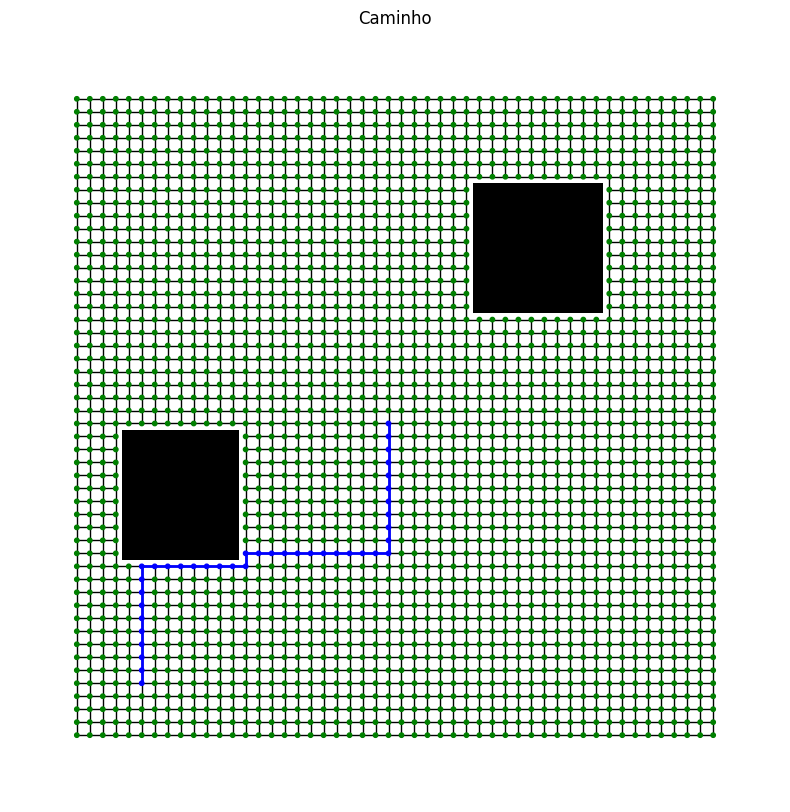

In [10]:
print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')
    
    controller.qi = controller.get_robot_position()
    
    controller.set_goal(np.array([-4,-4,0]))

    controller.generated_path_graph(n_grade=50, printmap=True)

    controller.send_generated_path()

    controller.control_loop()
else:
    print('Failed connecting to remote API server')

print('Program ended')

In [ ]:

def get_object_bounding_box(clientID, obj_handle):
    res, min_x = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_min_x, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter min_x para o objeto {obj_handle}')
        return None, None
    res, max_x = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_max_x, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter max_x para o objeto {obj_handle}')
        return None, None
    res, min_y = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_min_y, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter min_y para o objeto {obj_handle}')
        return None, None
    res, max_y = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_max_y, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter max_y para o objeto {obj_handle}')
        return None, None

    width = max_x - min_x
    height = max_y - min_y

    return width, height

def is_within_area(x, y, x_center, y_center, distance):
    return abs(x - x_center) <= distance and abs(y - y_center) <= distance

# Conectar-se ao CoppeliaSim
sim.simxFinish(-1)  # Fechar todas as conexões existentes
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

# Inicializar lista de retângulos
rectangles = []

if clientID != -1:
    print('Conectado ao CoppeliaSim')

    # Obter o handle do robô e do destino
    res, pioneer_handle = sim.simxGetObjectHandle(clientID, 'Pioneer_p3dx', sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter o handle do PioneerP3DX')
        pioneer_handle = None

    res, goal_handle = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter o handle do Goal')
        goal_handle = None

    # Obter a posição do Pioneer e do Goal
    res, pioneer_pos = sim.simxGetObjectPosition(clientID, pioneer_handle, -1, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter a posição do PioneerP3DX')
        pioneer_pos = (0, 0)

    res, goal_pos = sim.simxGetObjectPosition(clientID, goal_handle, -1, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter a posição do Goal')
        goal_pos = (0, 0)

    # Obter todos os objetos na simulação
    res, objects = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)
    if res == sim.simx_return_ok:
        print('Número de objetos na simulação:', len(objects))

        for obj in objects:
            # Ignorar o robô e o destino
            if obj in [pioneer_handle, goal_handle]:
                continue

            # Obter a posição do objeto
            res, position = sim.simxGetObjectPosition(clientID, obj, -1, sim.simx_opmode_blocking)
            if res == sim.simx_return_ok:
                print(f'Posição do objeto {obj}:', position)

                # Obter as dimensões do objeto
                width, height = get_object_bounding_box(clientID, obj)
                if (width is not None and width > 0.1) and (height is not None and height > 0.1):
                    print(f'Dimensões do objeto {obj} - Largura: {width}, Altura: {height}')
                    
                    # Filtrar objetos que podem ser quadrantes indesejados
                    if width > 2 and height > 2:  # Ajuste os critérios conforme necessário
                        print(f'Ignorando o objeto {obj} por ser um quadrante indesejado')
                        continue

                    # Verificar se o objeto está dentro da área ao redor do Pioneer e do Goal
                    if (is_within_area(position[0], position[1], pioneer_pos[0], pioneer_pos[1], 1) or
                        is_within_area(position[0], position[1], goal_pos[0], goal_pos[1], 1)):
                        print(f'Ignorando o objeto {obj} por estar dentro da área ao redor do Pioneer ou Goal')
                        continue

                    # Adicionar retângulo à lista (x, y, largura, altura)
                    rectangles.append((position[0], position[1], width, height))
                else:
                    print(f'Erro ao obter as dimensões do objeto {obj}')
            else:
                print(f'Erro ao obter a posição do objeto {obj}')

    else:
        print('Erro ao obter objetos:', res)

    # Desconectar-se do CoppeliaSim
    sim.simxFinish(clientID)
    print('Desconectado do CoppeliaSim')
else:
    print('Falha ao conectar-se ao CoppeliaSim')


In [ ]:
# Criar os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Espaço de ocupação no primeiro subplot
for rect in rectangles:
    x, y, width, height = rect
    ax1.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='r', facecolor='r'))  # Retângulos sólidos

# Marcar a posição do Pioneer com um quadrado azul
pioneer_square = plt.Rectangle((pioneer_pos[0] - 0.5, pioneer_pos[1] - 0.5), 1, 1, edgecolor='blue', facecolor='blue')
ax1.add_patch(pioneer_square)

# Marcar a posição do Goal com uma estrela verde
ax1.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax1.set_xlim(-5, 5) 
ax1.set_ylim(-5, 5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Espaço de Trabalho no Plano XY')
ax1.set_aspect('equal', adjustable='box')

# Adicionar legenda ao primeiro subplot
ax1.legend()

print(rectangles)
# Espaço de configuração no segundo subplot
for rect in rectangles:
    x, y, width, height = rect
    width = width + 1
    height = height + 1
    ax2.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='r', facecolor='r'))  # Retângulos sólidos

# Marcar a posição do Pioneer com um triângulo azul
ax2.plot(pioneer_pos[0], pioneer_pos[1], marker='.', color='blue', markersize=10, label='Pioneer')

# Marcar a posição do Goal com uma estrela verde
ax2.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax2.set_xlim(-5, 5)  # Ajuste os limites conforme necessário
ax2.set_ylim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Espaço de Configuração 2D')
ax2.set_aspect('equal', adjustable='box')

# Adicionar legenda ao segundo subplot
ax2.legend()

# Ajustar o layout para melhor visualização
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pioneer_pos = np.array(pioneer_pos[0:2])
goal_pos = np.array(goal_pos [0:2])

# Handle do Goal
returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)     
returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [goal_pos[0], goal_pos[1], 0], sim.simx_opmode_oneshot_wait)

print(pioneer_pos)
print(goal_pos) #[3.45000005 2.2249999 ]

atract_gain = 20
repulse_gain = 100

def posgrad(current_pos, goal_pos, rectangles, worry_radius):
    x, y = current_pos
    goal_x, goal_y = goal_pos
    
    # Calculate the gradient of the function f
    dx = atract_gain*((x - goal_x) / np.sqrt((x - goal_x)**2 + (y - goal_y)**2))
    dy = atract_gain*((y - goal_y) / np.sqrt((x - goal_x)**2 + (y - goal_y)**2))
    
    # Initialize gradient adjustments
    gradx_adjustment = 0
    grady_adjustment = 0
    
    # Check the distance to each obstacle
    for rect in rectangles:
        rect_x, rect_y, width, height = rect
        # Calculate the closest point on the rectangle to the current position
        closest_x = np.clip(x, rect_x - (width + 1) / 2, rect_x + (width + 1)/ 2)
        closest_y = np.clip(y, rect_y - (height + 1) / 2, rect_y + (height +1) / 2)
        # Compute the distance from the current position to this closest point
        dist_to_rect = np.sqrt((x - closest_x)**2 + (y - closest_y)**2)
        print(dist_to_rect)
        if dist_to_rect < worry_radius:
            # Calculate gradient adjustment based on the proximity to the obstacle
            # Here, we use an inverse square law for the adjustment magnitude
            adjustment_factor = (worry_radius - dist_to_rect) / worry_radius
            gradx_adjustment +=  repulse_gain*(x - closest_x)*adjustment_factor
            grady_adjustment +=  repulse_gain*(y - closest_y)*adjustment_factor
    # Return the adjusted gradient
    gradx = dx + gradx_adjustment
    grady = dy + grady_adjustment
    return gradx, grady

path = [pioneer_pos.copy()]
current_pos = pioneer_pos.copy()
alpha = 0.01
threshold = 0.1
max_try = 0

worry_radius = 1.0

while np.linalg.norm(current_pos - goal_pos) > threshold:

    gradx, grady = posgrad(current_pos,goal_pos,rectangles,worry_radius)
    force = -np.array([gradx,grady])
    current_pos += alpha * force
    path.append(current_pos.copy())

    max_try = max_try + 1
    if(max_try > 100000):
        break

print(f"Resultado com: {max_try}")

path = np.array(path)

fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))


for rect in rectangles:
    x, y, width, height = rect
    ax1.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='r', facecolor='r'))  # Retângulos sólidos


ax1.set_xlim(-5, 5)  # Ajuste os limites conforme necessário
ax1.set_ylim(-5, 5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Espaço de Ocupação no Plano XY')
ax1.set_aspect('equal', adjustable='box')

ax1.plot(path[:, 0], path[:, 1], marker='.', color='blue', label='Path')
ax1.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax1.legend()

plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

pioneer_pos = np.array(pioneer_pos[0:2])
goal_pos = np.array(goal_pos[0:2])

# goal_pos = np.array([4,2])
# goal_pos = np.array([-4,-2])
# goal_pos = np.array([4,4])



print(pioneer_pos)
print(goal_pos)  # [3.45000005 2.2249999 ]

xi = 1
eta =0.1
Q_star = 10
R_switch = 0.5

x = np.linspace(-5, 5, 300)
y = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(x, y)

def attractive_potential(X, Y, goal, R_switch, xi):
    dist = np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
    U_att = np.zeros_like(dist)

    mask_conic = dist > R_switch
    U_att[mask_conic] = xi * (dist[mask_conic] - R_switch)

    mask_paraboloid = dist <= R_switch
    U_att[mask_paraboloid] = 0.5 * xi * dist[mask_paraboloid]**2

    return U_att

def repulsive_potential(X, Y, obstacles, Q_star, eta):
    U_rep = np.zeros_like(X)
    for rect in obstacles:
        x, y, width, height = rect
        dist_x = np.maximum(0, np.abs(X - x) - ((width +1)/ 2))
        dist_y = np.maximum(0, np.abs(Y - y) - ((height +1) / 2))
        dist = np.sqrt(dist_x**2 + dist_y**2)
        mask = dist < Q_star
        U_rep[mask] += 0.5 * eta * (1.0 / (dist[mask] + 0.1) - 1.0 / Q_star)**2
    return U_rep

U_att = attractive_potential(X, Y, goal_pos, R_switch, xi)
U_rep = repulsive_potential(X, Y, rectangles, Q_star, eta)
U_tot = U_att + U_rep

grad_U_x, grad_U_y = np.gradient(U_tot, x, y)

def calculate_tangential_force(grad):
    tangential_force = np.array([-grad[1], grad[0]])
    return tangential_force / np.linalg.norm(tangential_force)

path = [pioneer_pos.copy()]
current_pos = pioneer_pos.copy()
alpha = 0.01
beta = -10
threshold = 0.2
max_try = 0


while np.linalg.norm(current_pos - goal_pos) > threshold:
    ix = np.argmin(np.abs(x - current_pos[0]))
    iy = np.argmin(np.abs(y - current_pos[1]))

    grad = np.array([grad_U_y[iy, ix],grad_U_x[iy, ix]])

    repulsive_force = -grad
    if np.linalg.norm(current_pos - goal_pos) > 0.7:
        tangential_force = calculate_tangential_force(grad)
    else:
        tangential_force = 0
    total_force = repulsive_force + beta * tangential_force

    current_pos += alpha * total_force

    current_pos[0] = np.clip(current_pos[0], -4.8, 4.8)
    current_pos[1] = np.clip(current_pos[1], -4.8, 4.8)

    path.append(current_pos.copy())

    max_try += 1
    if max_try > 10000:
        break

print(f"Resultado com: {max_try}")


path = np.array(path)

window_length = 51 
polyorder = 5  

# smoothed_path_x = savgol_filter(path[:, 0], window_length, polyorder)
# smoothed_path_y = savgol_filter(path[:, 1], window_length, polyorder)
# smoothed_path = np.vstack((smoothed_path_x, smoothed_path_y)).T

fig, ax3 = plt.subplots(1, 1, figsize=(18, 6))

c = ax3.contourf(X, Y, U_tot, levels=100, cmap='jet')
ax3.plot(path[:, 0], path[:, 1], marker='.', color='white', label='Original Path')
# ax3.plot(smoothed_path[:, 0], smoothed_path[:, 1], marker='.', color='blue', label='Smoothed Path')
ax3.plot(goal_pos[0], goal_pos[1], marker='*', color='black', markersize=10, label='Goal')

ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Campo de Potencial e Caminho Planejado')
ax3.set_aspect('equal', adjustable='box')

ax3.legend()

fig.colorbar(c, ax=ax3)

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.patches as patches
fig, ax1 = plt.subplots()

# Espaço de ocupação no primeiro subplot
for rect in rectangles:
    x, y, width, height = rect
    ax1.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='k', facecolor='k'))  # Retângulos sólidos

ax1.set_xlim(-5, 5) 
ax1.set_ylim(-5, 5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Espaço de Trabalho no Plano XY')
ax1.set_aspect('equal', adjustable='box')
ax1.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax1.set_xticks(np.arange(-5, 5, 0.1))
ax1.set_yticks(np.arange(-5, 5, 0.1))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 

def is_point_in_rectangle(px, py, rect):
    x, y, width, height = rect
    width = width + 1
    height = height + 1
    return x <= px <= x + width and y <= py <= y + height

def real2grid(real_x, real_y, n):
    min_val, max_val = -5, 5

    cell_size = (max_val - min_val) / n 

    j = int((real_x - min_val) / cell_size)
    i = int((max_val - real_y) / cell_size)

    return (i, j)

def grid2real(i, j, n):

    min_val, max_val = -5, 5

    cell_size = (max_val - min_val) / n

    real_x = min_val + (i+0.5) * cell_size 
    real_y = max_val - (j+0.5) * cell_size 

    return real_x, real_y


n=50

grid = np.zeros((n, n))

cell_size = 10/n

x = np.linspace(-5, 5, n)
y = np.linspace(-5, 5, n)


X, Y = np.meshgrid(x, y)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        px, py = X[i, j], Y[i, j]
        point_in_rectangles = [is_point_in_rectangle(px, py, rect) for rect in rectangles]
        if any(point_in_rectangles):
                grid[i][j] = 1

G = nx.grid_2d_graph(n, n) 
# G = nx.convert_node_labels_to_integers(G)
node_colors = {node: 'green' for node in G.nodes()}

for r in range(n):
    for c in range(n):
        if grid[r][c] == 1:  
            G.remove_node((r,c))

#Plot dos nós livre
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(-5, 5, cell_size))
ax.set_yticks(np.arange(-5, 5, cell_size))
obj = ax.imshow(grid, cmap='Greys', extent=(-5,5, -5,5))

posn = {node: (grid2real(node[1],node[0],n)) for node in G.nodes()}
nx.draw(G, posn, font_size=0,node_color="g", with_labels=False, node_size=10, ax=ax) 
plt.draw()


#Plot dos pontos de partida e chegada
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, aspect='equal')


start_node = real2grid(0, 0, n)
node_colors[start_node] = 'red'
print(start_node[0])
end_node = real2grid(-4.9,0,n)
node_colors[end_node] = 'yellow'
print(end_node)

ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(-5, 5, cell_size))
ax.set_yticks(np.arange(-5, 5, cell_size))
obj = ax.imshow(grid, cmap='Greys', extent=(-5, 5, -5,5))

node_colors_list = [node_colors[node] for node in G.nodes()]
posz = {node: grid2real(node[1], node[0], n) for node in G.nodes()}
nx.draw(G, posz, font_size=0, with_labels=False, node_size=10, node_color=node_colors_list, ax=ax) 
plt.draw()

#plot caminho
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(-5, 5, cell_size))
ax.set_yticks(np.arange(-5, 5, cell_size))

path = nx.shortest_path(G, source=start_node, target=end_node)

for node in path:
    print("path",node)
    node_colors[node] = 'blue'

node_colors_list = [node_colors[node] for node in G.nodes()]

posz = {node: grid2real(node[1], node[0], n) for node in G.nodes()}
nx.draw(G, posz, font_size=0, with_labels=False, node_size=10, node_color=node_colors_list, ax=ax) 
obj = ax.imshow(grid, cmap='Greys', extent=(-5, 5, -5,5))
edge_list = [(path[i], path[i+1]) for i in range(len(path)-1)]
nx.draw_networkx_edges(G, posz, edgelist=edge_list, edge_color='blue', width=2, ax=ax)
plt.title("Caminho")
plt.draw()

# plt.draw()


# fig = plt.figure(figsize=(10,10), dpi=100)
# ax = fig.add_subplot(111, aspect='equal')

# x_path = []
# y_path = []

# for pos in path:
#    px,py = grid2real(pos[1], pos[0], n)
#    x_path.append(px)
#    y_path.append(py)

# # print(path)
# # nx.draw_networkx_nodes(G, posn, nodelist=path, node_size=100, node_color='b')

# # nx.draw(G, posn, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)
# # Plota o grid
# # ax.figure(figsize=(10, 10))
# ax.plot(x_path, y_path, color='b')
# # ax.scatter(1,1,color='red')
# # plt.title(f'Grid {n}x{n}')
# plt.xlabel('X')
# plt.ylabel('Y')
# # ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
# ax.set_xticks(np.linspace(-5, 5, n))
# ax.set_yticks(np.linspace(-5, 5, n))
# plt.show()


In [ ]:
# start_node = (10,1)
# end_node = (30,59)

# fig = plt.figure(figsize=(10,10), dpi=100)
# ax = fig.add_subplot(111, aspect='equal')

# obj = ax.imshow(grid, cmap='Greys', extent=(-5, 5, -5,5))

# path = nx.shortest_path(G, source=start_node, target=end_node)
# nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')
# plt.show()

def grid2real(i, j, n):

    min_val, max_val = -5, 5

    cell_size = (max_val - min_val) / n

    real_x = min_val + (i+0.5) * cell_size 
    real_y = max_val - (j+0.5) * cell_size 

    return real_x, real_y
x_path = []
y_path =[]
for pos in path:

    # if pos[0]<=int(n/2): 
    #     l = -1
    # x_path.append(pos[0]*5/60*l)
    # l=1
    # if pos[1] <=int(n/2): 
    #     l = -1
    # y_path.append(pos[1]*5/60*l)
    # l=1
#    print(pos[0])
   px,py = grid2real(pos[1], pos[0], n)
   print(px,',',py)
   x_path.append(px)

   y_path.append(py)

fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(x_path, y_path, color='b')
obj = ax.imshow(grid, cmap='Greys', extent=(-5, 5, -5,5))